[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/delalamo/dda_scripts/blob/main/notebooks/mdds/mdds_tfp.ipynb)
# Running MDDS on protein structures

This notebook predicts distance distributions between pairs of amino acid residues using the [molecular dynamics of dummy spin label (MDDS)](https://pubs.acs.org/doi/10.1021/jp311723a) method. The script uses the [No U-Turn Sampler](http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf), rather than classical Molecular Dynamics simulations, to sample the conformational space available to the dummy atom. The sampler is implemented in [TensorFlow Probability](https://www.tensorflow.org/probability/examples/TensorFlow_Probability_on_JAX), and most of the code uses Jax.

To run this notebook, fill out the residue information below under "Step 2", then go to Runtime -> Run all.

Currently I am in the process of adding functionality for custom PDBs.

In [1]:
#@title **Step 1:** Setup Colab environment

%shell git clone https://github.com/biopython/biopython.git
%shell pip install biopython/

%shell git clone https://github.com/delalamo/dda_scripts

from dda_scripts.notebooks.mdds import util

import jax.numpy as jnp
from jax import grad
from jax import jit
from jax import random
from jax import value_and_grad
from jax import vmap
from tensorflow_probability.substrates import jax as tfp

import matplotlib.pyplot as plt
import numpy as np
import os
from urllib.request import urlretrieve

from google.colab import files

import Bio.PDB

Cloning into 'biopython'...
remote: Enumerating objects: 97428, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 97428 (delta 39), reused 28 (delta 15), pack-reused 97346
Receiving objects: 100% (97428/97428), 58.66 MiB | 8.55 MiB/s, done.
Resolving deltas: 100% (73389/73389), done.
Processing ./biopython
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for biopython: filename=biopython-1.80.dev0-cp37-cp37m-linux_x86_64.whl size=2839070 sha256=b3361c1b52476d85d051a76368b92aa8bdba6219b45ccf0178d64ab5d64e3bd5
  Stored in directory: /tmp/pip-ephem-wheel-cache-xkouzb2k

In [22]:
#@title **Step 2:** Define input parameters
#@markdown PDB ID of interest (must be four digits)
pdb_id = "4DJI" #@param {type:"string"}
upload_from_pdb = True  #@param {type:"boolean"}

#@markdown Residue and chain indices (separated by a colon; e.g. 75:A or 115:B):
residue1 = "117:A"  #@param {type:"string"}
residue2 = "441:A" #@param {type:"string"}

def to_res_chain( reschain ):
  data = reschain.split( ":" )
  return int( data[ 0 ] ), data[ 1 ]

residue1, chain1 = to_res_chain( residue1 )
residue2, chain2 = to_res_chain( residue2 )


In [26]:
#@title **Step 4:** Retrieve files and convert to model

# Download PDB file
# Make sure the PDB ID is four digits long
if upload_from_pdb:
  assert len( pdb_id ) == 4
  pdbfile = f'{ pdb_id }.pdb'
  urlretrieve( f'http://files.rcsb.org/download/{ pdb_id }.pdb',
              pdbfile )
else:
  pdbfile = files.upload()
  pdbfile = list( pdbfile.keys() )[ 0 ]
model = Bio.PDB.PDBParser().get_structure( "TEMP", pdbfile )



In [27]:
#@title **Step 5:** Set up parameters and fit function, run the prediction

ca = util.get_atoms( model, "CA" )
cb = util.get_atoms( model, "CB" )
n = util.get_atoms( model, "N" )

residues = [ ( residue1, chain1 ), ( residue2, chain2 ) ]

params = util.set_params( residues )

headers = list( params.keys() )
x0 = tuple( params.values() )

clash_atoms = { ( r, c ): util.calc_clashes( r, c, model, 10. ) for r, c in residues }

@jit
def log_likelihood_coords( *x ):
  ll = 0.

  res_pos = util.get_positions( x, headers, residues )

  for ( res, chain ), xyz in res_pos.items():

      ll += util.xyz_energy_clash(
        xyz,
        ca[ ( res, chain ) ],
        cb[ ( res, chain ) ],
        n[ ( res, chain ) ],
        clash_atoms[ ( res, chain ) ]
    )
  
  return ll

init_key, sample_key = random.split( random.PRNGKey( 0 ) )
kernel = tfp.mcmc.NoUTurnSampler( log_likelihood_coords, 1e-2 )

states, log_probs = tfp.mcmc.sample_chain( 500,
      current_state=x0,
      kernel=kernel,
      trace_fn=lambda _, results: results.target_log_prob,
      num_burnin_steps=500,
      seed=init_key )

In [28]:
states = np.asarray( states )
amps = np.zeros( 800 )
for xyz1 in states[ :3, : ].transpose():
  for xyz2 in states[ 3:, : ].transpose():
    dist = np.linalg.norm( xyz1 - xyz2 )
    if dist <= 80:
      amps[ int( dist * 10 ) ] += 1
plt.plot( np.arange( 0, 80, 0.1 ), amps )

<function matplotlib.pyplot.show>

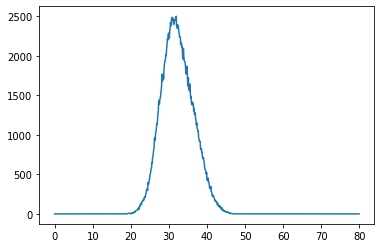